In [1]:
import sys
import os

In [2]:
PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from yield_curve.data_loader import load_treasury_yields
from yield_curve.curve_builder import YieldCurve
from yield_curve.rates import zero_rate, forward_rate, instantaneous_forward_rates

In [4]:
df = load_treasury_yields(start="2024-01-01")
latest = df.iloc[-1]

yc = YieldCurve(latest)

print("2.75Y rate:", yc.rate(2.75))
print("7Y rate:", yc.rate(7))
print("10Y DF:", yc.discount_factor(10))

2.75Y rate: 0.03678102235788929
7Y rate: 0.04032285326829821
10Y DF: 0.6505090947233166


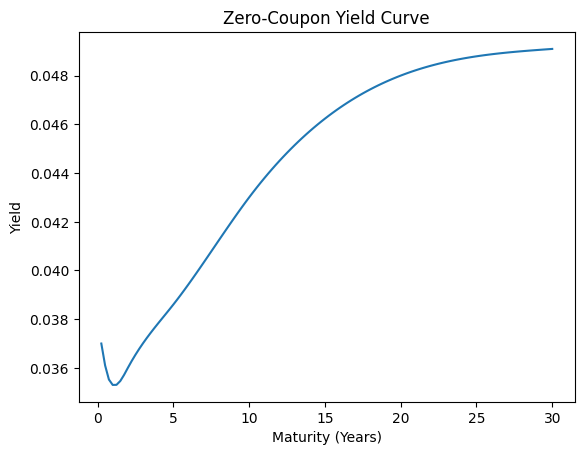

In [5]:
maturities = np.linspace(0.25, 30, 120)
zero_rates = [zero_rate(yc, t) for t in maturities]

plt.plot(maturities, zero_rates)
plt.title("Zero-Coupon Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.show()

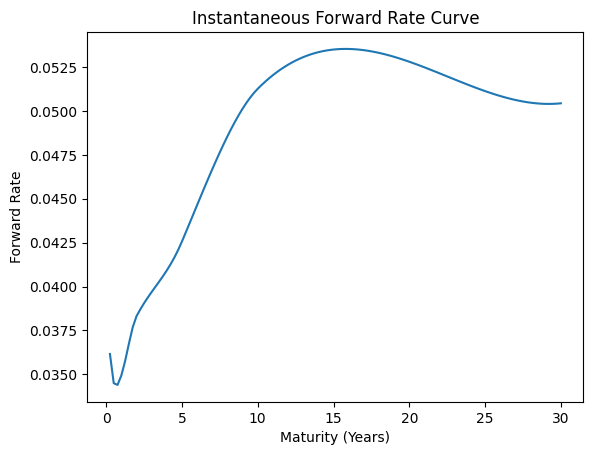

In [6]:
forward_rates = instantaneous_forward_rates(yc, maturities)

plt.plot(maturities, forward_rates)
plt.title("Instantaneous Forward Rate Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate")
plt.show()

In [7]:
from bond_engine.bond_pricer import Bond, price_bond, yield_to_maturity

bond = Bond(
    face_value=100,
    coupon_rate=0.06,
    maturity=5,
    frequency=2
)

price = price_bond(bond, yc)
print("Bond price:", round(price, 2))

ytm = yield_to_maturity(bond, price)
print("Implied YTM:", round(ytm * 100, 2), "%")

Bond price: 109.56
Implied YTM: 3.84 %


In [8]:
from bond_engine.bond_pricer import (
    macaulay_duration,
    modified_duration,
    convexity
)

In [9]:
D_mac = macaulay_duration(bond, yc)
D_mod = modified_duration(bond, yc)
C = convexity(bond, yc)

print(f"Macaulay Duration: {D_mac:.2f} years")
print(f"Modified Duration: {D_mod:.2f}")
print(f"Convexity: {C:.2f}")

Macaulay Duration: 4.42 years
Modified Duration: 4.26
Convexity: 21.09


In [10]:
from bond_engine.rate_shock import ShockedYieldCurve
from bond_engine.bond_pricer import price_bond

In [11]:
shocks = [-100, -50, 50, 100]  # bp
base_price = price_bond(bond, yc)

results = []

for s in shocks:
    shocked_curve = ShockedYieldCurve(yc, s)
    shocked_price = price_bond(bond, shocked_curve)

    results.append({
        "Shock (bp)": s,
        "Price": shocked_price,
        "Pct Change": (shocked_price / base_price - 1) * 100
    })

pd.DataFrame(results)

,Shock (bp),Price,Pct Change
0,-100,114.522935,4.530519
1,-50,112.011540,2.238250
2,50,107.164874,-2.185532
3,100,104.826785,-4.319617


In [12]:
D = modified_duration(bond, yc)
C = convexity(bond, yc)

approx_results = []

for s in shocks:
    dy = s / 10000
    approx_pct = -D * dy + 0.5 * C * dy**2

    approx_results.append({
        "Shock (bp)": s,
        "Approx % Change": approx_pct * 100
    })

pd.DataFrame(approx_results)

,Shock (bp),Approx % Change
0,-100,4.364387
1,-50,2.155836
2,50,-2.103121
3,100,-4.153527


In [13]:
df_actual = pd.DataFrame(results).set_index("Shock (bp)")
df_approx = pd.DataFrame(approx_results).set_index("Shock (bp)")

comparison = df_actual.join(df_approx)
comparison

,Price,Pct Change,Approx % Change
Shock (bp),,,
-100,114.522935,4.530519,4.364387
-50,112.011540,2.238250,2.155836
50,107.164874,-2.185532,-2.103121
100,104.826785,-4.319617,-4.153527


<Axes: title={'center': 'Actual vs Duration+Convexity Approximation'}, xlabel='Shock (bp)'>

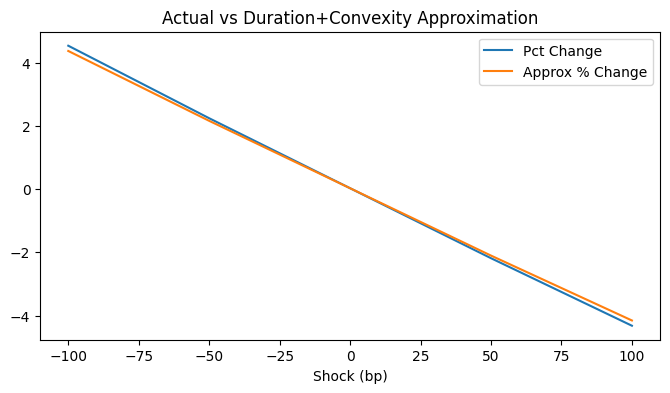

In [14]:
comparison[["Pct Change", "Approx % Change"]].plot(
    title="Actual vs Duration+Convexity Approximation",
    figsize=(8, 4)
)

In [15]:
from bond_engine.portfolio import BondPortfolio

In [16]:
bond_short = Bond(100, 0.04, 2)
bond_mid   = Bond(100, 0.05, 5)
bond_long  = Bond(100, 0.07, 10)

portfolio = BondPortfolio(
    bonds=[bond_short, bond_mid, bond_long],
    weights=[0.33, 0.34, 0.33]
)

print("Portfolio Price:", portfolio.price(yc))
print("Portfolio Duration:", portfolio.duration(yc))
print("Portfolio Convexity:", portfolio.convexity(yc))

Portfolio Price: 109.26113615081235
Portfolio Duration: 4.869922530115136
Portfolio Convexity: 31.137391267357998


In [17]:
P = np.array([
    price_bond(bond_short, yc),
    price_bond(bond_mid, yc),
    price_bond(bond_long, yc)
])

D = np.array([
    macaulay_duration(bond_short, yc),
    macaulay_duration(bond_mid, yc),
    macaulay_duration(bond_long, yc)
])

C = np.array([
    convexity(bond_short, yc),
    convexity(bond_mid, yc),
    convexity(bond_long, yc)
])

H = 5.0
C_target = np.mean(C)  # neutral convexity target

A = np.array([
    P,
    P * D,
    P * C
])

b = np.array([1.0, H, C_target])

weights = np.linalg.solve(A, b)
weights

immunized = BondPortfolio(
    bonds=[bond_short, bond_mid, bond_long],
    weights=weights
)

print("Duration:", immunized.duration(yc))
print("Convexity:", immunized.convexity(yc))

Duration: 5.000000000000002
Convexity: 0.27512224826517095


In [18]:
H = 5.0
base_fv = immunized.future_value(yc, H)

for shock in [-50, 50]:
    sc = ShockedYieldCurve(yc, shock)
    shocked_fv = immunized.future_value(sc, H)
    print(
        f"Shock {shock}bp:",
        round((shocked_fv / base_fv - 1) * 100, 4), "%"
    )


Shock -50bp: -0.4768 %
Shock 50bp: 0.4843 %


In [21]:
from bond_engine.key_rate_shock import key_rate_duration

KEY_RATES = np.array([0.5, 1, 2, 5, 10, 30])  # years

krds = {}
for k in KEY_RATES:
    krds[k] = key_rate_duration(bond_long, yc, k)

pd.Series(krds)


0.5     0.036971
1.0     0.068870
2.0     0.132994
5.0     0.295360
10.0    5.644415
30.0   -0.000000
dtype: float64

In [22]:
sum(krds.values())

6.178610144476289

In [23]:
modified_duration = macaulay_duration(bond_long, yc) / (1 + yc.rate(10)/2)
modified_duration

7.451956558019974